# Object Detection


This lab is similar to the previous lab, except now instead of printing out the bounding box coordinates, you can visualize these bounding boxes on top of the image!

## Setup


In [3]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

import os

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.4.1
The following GPU devices are available: 


### Important: Modify the cwd to the folder where your car video is

In [38]:
##########################
##########################
####### MODIFY THIS ######
##########################
##########################

# This is the path to the folder containing the video
cwd = "/home/nblain/Bureau/Alva/"

# This is the video name + extension
car_video_name = 'Paris.mp4'
image_folder = cwd + car_video_name.split('.')[0]


# This is the number of frames per second for video slicing
FPS = 5

# This is the (x1, y1) and (x2, y2) points connecting the left and right guiding lines
# y (0 = top, 1 = bottom)
# x (0 = left, 1 = right)
leftline = [(0.25, 1), (0.53, 0.5)]
rightline = [(0.85, 1), (0.53, 0.5)]

### Select and load the model
As in the previous lab, you can choose an object detection module. Here are two that we've selected for you:
* [ssd + mobilenet V2](https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2) small and fast.
* [FasterRCNN + InceptionResNet V2](https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1): high accuracy

In [39]:
# you can switch the commented lines here to pick the other model

# ssd mobilenet version 2
# module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

# You can choose inception resnet version 2 instead
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

#### Load the model

Next, you'll load the model specified by the `module_handle`.
- This will take a few minutes to load the model.

In [40]:
model = hub.load(module_handle)
detector = model.signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [41]:
def resize_image(filename, new_width=640, new_height=360, display=False):
    '''
    Resizes an image and saves it locally.
    
    Args:
        filename (string) -- filename of the image
        new_width (int) -- size in pixels used for resizing the width of the image
        new_height (int) -- size in pixels used for resizing the length of the image
        
    Returns:
        (string) -- path to the saved image
    '''
    
    # opens the image
    pil_image = Image.open(filename)
    
    # resizes the image. will crop if aspect ratio is different.
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    
    # converts to the RGB colorspace
    pil_image_rgb = pil_image.convert("RGB")
    
    # saves the image to the temporary file created earlier
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    
    print("Image downloaded to %s." % filename)
    
    if display:
        display_image(pil_image)

    return filename

### Draw bounding boxes

To build on what you saw in the previous lab, you can now visualize the predicted bounding boxes, overlaid on top of the image.  
- You can use `draw_boxes` to do this.  It will use `draw_bounding_box_on_image` to draw the bounding boxes.

In [42]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=1,
                               display_str_list=()):

    """
    Adds a bounding box to an image.
    
    Args:
        image -- the image object
        ymin -- bounding box coordinate
        xmin -- bounding box coordinate
        ymax -- bounding box coordinate
        xmax -- bounding box coordinate
        color -- color for the bounding box edges
        font -- font for class label
        thickness -- edge thickness of the bounding box
        display_str_list -- class labels for each object detected
    
    
    Returns:
        No return.  The function modifies the `image` argument 
                    that gets passed into this function
    
    """
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    
    # scale the bounding box coordinates to the height and width of the image
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    
    # define the four edges of the detection box
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_line(image,
                               points,
                               color,
                               thickness=1):

    """
    Adds a bounding box to an image.
    
    Args:
        image -- the image object
        points -- coordinates for the points
        color -- color for the bounding box edges
        thickness -- edge thickness of the line
    
    
    Returns:
        No return.  The function modifies the `image` argument 
                    that gets passed into this function
    
    """
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size

    [(xmin, ymin), (xmax, ymax)] = points
    xmin *= im_width
    xmax *= im_width
    ymin *= im_height
    ymax *= im_height
    
    # define the four edges of the detection box
    draw.line([(xmin, ymin), (xmax, ymax)],
            width=thickness,
            fill=color)
    
def findbound(y, line):
  ''' Finds the x coordinate on the given line
  [(0.25, 1), (0.53, 0.5)]'''

  [(x1, y1), (x2, y2)] = line

  if y < y2 or y > y1:
    return -1

  proportion = float(y-y1)/(y2-y1)

  return x1 + proportion*(x2-x1)

def draw_boxes(image, boxes, class_names, scores, max_boxes=100, min_score=0.3, showlines = False):
    """
    Overlay labeled boxes on an image with formatted scores and label names.
    
    Args:
        image -- the image as a numpy array
        boxes -- list of detection boxes
        class_names -- list of classes for each detected object
        scores -- numbers showing the model's confidence in detecting that object
        max_boxes -- maximum detection boxes to overlay on the image (default is 10)
        min_score -- minimum score required to display a bounding box
        showlines (bool) -- boolean of whether to show the guiding lines
    
    Returns:
        image -- the image after detection boxes and classes are overlaid on the original image.
    """
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              10)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):

        # filter out only some categories
        if class_names[i].decode("ascii").lower() not in \
        ["car", "van", "motorcycle", "bicycle", "bus"]: continue
        
        # only display detection boxes that have the minimum score or higher
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])     
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

            # draw guiding lines
            if showlines:
              draw_line(image_pil,
                            points = leftline,
                              color = "blue")
              
              draw_line(image_pil,
                            points = rightline,
                              color = "blue")
              
            # filter out only boxes within the guiding lines
            leftbound = findbound(ymin, line = leftline)
            rightbound = findbound(ymin, line = rightline)

            display_str = str(class_names[i].decode("ascii"))

            # distance formula from the paper
            height = (ymax - ymin)
            width = (xmax - xmin)
            # dist = 0.00540 *(2021.256 - 1.276714 * height - 0.6042361 * width + 0.0004751 * height * width)
            dist = 0.5/width

            if xmax < leftbound or xmin > rightbound or leftbound == -1 or rightbound == -1: 
              color = 'white'
            else:
              color = 'yellow'
              display_str += f" {dist:.1f}m"

            # draw one bounding box and overlay the class labels onto the image
            draw_bounding_box_on_image(image_pil,
                                       ymin,
                                       xmin,
                                       ymax,
                                       xmax,
                                       color = color,
                                       font = font,
                                       display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
        
    return image

### run_detector

This function will take in the object detection model `detector` and the path to a sample image, then use this model to detect objects.
- This time, run_dtector also calls `draw_boxes` to draw the predicted bounding boxes.

In [43]:
def load_img(path):
    '''
    Loads a JPEG image and converts it to a tensor.
    
    Args:
        path (string) -- path to a locally saved JPEG image
    
    Returns:
        (tensor) -- an image tensor
    '''
    
    # read the file
    img = tf.io.read_file(path)
    
    # convert to a tensor
    img = tf.image.decode_jpeg(img, channels=3)
    
    return img


def run_detector(detector, path, showlines = False, verbose = True):
    '''
    Runs inference on a local file using an object detection model.
    
    Args:
        detector (model) -- an object detection model loaded from TF Hub
        path (string) -- path to an image saved locally
        showlines (bool) -- boolean of whether to show the guiding lines
        verbose (bool) -- boolean of whether to print out number of objects found and inference time
    '''
    
    # load an image tensor from a local file path
    img = load_img(path)

    # add a batch dimension in front of the tensor
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    
    # run inference using the model
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    # save the results in a dictionary
    result = {key:value.numpy() for key,value in result.items()}

    # print results
    if verbose:
      print("Found %d objects." % len(result["detection_scores"]))
      print("Inference time: ", end_time-start_time)
    
    # draw predicted boxes over the image
    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

    return image_with_boxes

### Segment the video into frames!

In [44]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [45]:
# Segment video into frames
import cv2
from os import makedirs
from os.path import splitext, dirname, basename, join

def save_frames(video_path: str, frame_dir: str, fps:int = FPS,
                name="image", ext="jpg"):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return
    if frame_dir[-1:] == "\\" or frame_dir[-1:] == "/":
        frame_dir = dirname(frame_dir)
    
    makedirs(frame_dir, exist_ok=True)
    base_path = join(frame_dir, name)

    idx = 0
    while cap.isOpened():
        idx += 1
        ret, frame = cap.read()
        if ret:
            if cap.get(cv2.CAP_PROP_POS_FRAMES) == 1:  #Save 0 second frame
                cv2.imwrite("{}_{}.{}".format(base_path, "0000", ext),
                            frame)
            elif idx*fps < cap.get(cv2.CAP_PROP_FPS):
                continue
            else:  #Save frames 1 second at a time
                second = int(cap.get(cv2.CAP_PROP_POS_FRAMES)/idx)
                filled_second = str(second).zfill(4)
                cv2.imwrite("{}_{}.{}".format(base_path, filled_second, ext),
                            frame)
                idx = 0
        else:
            break

save_frames(cwd+car_video_name, cwd+car_video_name.split('.')[0])

### Run the detector on the sliced video images!

In [46]:
import os 
image_folder="/home/nblain/Bureau/Alva/Paris"
for img in os.listdir(image_folder):
    print(img)

image_0000.jpg
image_0001.jpg
image_0002.jpg
image_0003.jpg
image_0004.jpg
image_0005.jpg
image_0006.jpg
image_0007.jpg
image_0008.jpg
image_0009.jpg
image_0010.jpg
image_0011.jpg
image_0012.jpg
image_0013.jpg
image_0014.jpg
image_0015.jpg
image_0016.jpg
image_0017.jpg
image_0018.jpg
image_0019.jpg
image_0020.jpg
image_0021.jpg
image_0022.jpg
image_0023.jpg
image_0024.jpg
image_0025.jpg
image_0026.jpg
image_0027.jpg
image_0028.jpg
image_0029.jpg
image_0030.jpg
image_0031.jpg
image_0032.jpg
image_0033.jpg
image_0034.jpg
image_0035.jpg
image_0036.jpg
image_0037.jpg
image_0038.jpg
image_0039.jpg
image_0040.jpg
image_0041.jpg
image_0042.jpg
image_0043.jpg
image_0044.jpg
image_0045.jpg
image_0046.jpg
image_0047.jpg
image_0048.jpg
image_0049.jpg
image_0050.jpg


Image downloaded to /home/nblain/Bureau/Alva/Paris/image_0000.jpg.
Image downloaded to /home/nblain/Bureau/Alva/Paris/image_0001.jpg.
Image downloaded to /home/nblain/Bureau/Alva/Paris/image_0002.jpg.
Image downloaded to /home/nblain/Bureau/Alva/Paris/image_0003.jpg.
Image downloaded to /home/nblain/Bureau/Alva/Paris/image_0004.jpg.
Image downloaded to /home/nblain/Bureau/Alva/Paris/image_0005.jpg.
Image downloaded to /home/nblain/Bureau/Alva/Paris/image_0006.jpg.
Image downloaded to /home/nblain/Bureau/Alva/Paris/image_0007.jpg.
Image downloaded to /home/nblain/Bureau/Alva/Paris/image_0008.jpg.
Image downloaded to /home/nblain/Bureau/Alva/Paris/image_0009.jpg.
Image downloaded to /home/nblain/Bureau/Alva/Paris/image_0010.jpg.
Image downloaded to /home/nblain/Bureau/Alva/Paris/image_0011.jpg.
Image downloaded to /home/nblain/Bureau/Alva/Paris/image_0012.jpg.
Image downloaded to /home/nblain/Bureau/Alva/Paris/image_0013.jpg.
Image downloaded to /home/nblain/Bureau/Alva/Paris/image_0014.

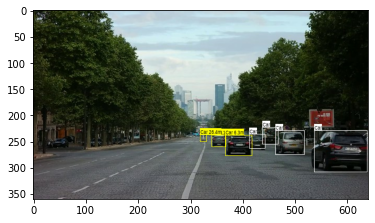

In [47]:
image_folder = cwd + car_video_name.split('.')[0]

images = sorted([img for img in os.listdir(image_folder) if img.endswith(".jpg")])

dir_name = cwd+car_video_name.split('.')[0]+"/processed/"
if not os.path.exists(dir_name):
  os.mkdir(dir_name)

for i, sliced_img in enumerate(images):
  image_path = resize_image(cwd+car_video_name.split('.')[0]+'/'+sliced_img)
  processed_img = run_detector(detector, image_path, showlines = False, verbose = False)
  # save and display the image
  plt.imshow(processed_img)

  plt.imsave(dir_name+str(i).zfill(4)+'.jpg', processed_img)

Test the code on one single image

In [ ]:
# image_folder = cwd + car_video_name.split('.')[0]
# image_num = 35
# images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")][image_num]

# image_path = resize_image(cwd+car_video_name.split('.')[0]+'/'+images)
# processed_img = run_detector(detector, image_path, showlines = False, verbose = False)
# # save and display the image
# plt.imshow(processed_img)

# plt.imsave(dir_name+str(image_num).zfill(4)+'.jpg', processed_img)

### Create the output video! (Video will be in same folder as the original video)

In [48]:
# Stitch video together
import cv2
import os

processed_image_folder = cwd + car_video_name.split('.')[0] + "/processed/"
video_name = cwd + 'stitched_'+car_video_name.split('.')[0]+'.avi'
images = sorted([img for img in os.listdir(processed_image_folder) if img.endswith(".jpg")])
frame = cv2.imread(os.path.join(processed_image_folder, images[0]))
height, width, layers = frame.shape
video = cv2.VideoWriter(video_name, 0, FPS, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(processed_image_folder, image)))

cv2.destroyAllWindows()
video.release()